In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import (
    hour, 
    mean, 
    sum, 
    count, 
    date_format, 
    concat, 
    col, 
    lit,  # Added lit
    lpad  # Added lpad
)

In [2]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("ParquetExplorer") \
    .getOrCreate()

# Read the parquet file
df = spark.read.parquet("sorted.parquet")

# Show a sample of the data and the schema
df.show(5)
df.printSchema()


25/02/12 18:48:08 WARN Utils: Your hostname, Sagniks-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.139 instead (on interface en0)
25/02/12 18:48:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/12 18:48:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-----------+------------+-------+-----------+--------+--------------------+-------------------+-----------------+---------------------+--------------------+-----------+----------+---------------------+----------+-----------------------------+----------------------------+--------------------------+--------------+---------------+--------------+--------------+---------+---------+----------------+---------+
|instance_id|cluster_size|user_id|database_id|query_id|   arrival_timestamp|compile_duration_ms|queue_duration_ms|execution_duration_ms| feature_fingerprint|was_aborted|was_cached|cache_source_query_id|query_type|num_permanent_tables_accessed|num_external_tables_accessed|num_system_tables_accessed|read_table_ids|write_table_ids|mbytes_scanned|mbytes_spilled|num_joins|num_scans|num_aggregations|       rn|
+-----------+------------+-------+-----------+--------+--------------------+-------------------+-----------------+---------------------+--------------------+-----------+----------+----

In [3]:
# Extract date and hour from arrival_timestamp and create hourly aggregations
hourly_stats = df.groupBy(
        concat(
            date_format(col("arrival_timestamp"), "yyyyMMdd"),
            lit(" "),
            lpad(hour(col("arrival_timestamp")).cast("string"), 2, "0")
        ).alias("date_hour")
    ) \
    .agg(
        # Performance metrics
        mean("compile_duration_ms").alias("avg_compile_time"),
        mean("queue_duration_ms").alias("avg_queue_time"),
        mean("execution_duration_ms").alias("avg_execution_time"),
        
        # Query characteristics
        mean("cluster_size").alias("avg_cluster_size"),
        sum("was_cached").alias("total_cached_queries"),
        sum("was_aborted").alias("total_aborted_queries"),
        
        # Resource usage
        mean("mbytes_scanned").alias("avg_mbytes_scanned"),
        mean("mbytes_spilled").alias("avg_mbytes_spilled"),
        
        # Query complexity metrics
        mean("num_joins").alias("avg_joins"),
        mean("num_scans").alias("avg_scans"),
        mean("num_aggregations").alias("avg_aggregations"),
        
        # Count of queries
        count("*").alias("total_queries")
    ) \
    .orderBy("date_hour")

# Display the results
hourly_stats.show(24, truncate=False)

# Save the grouped Spark DataFrame to Parquet
hourly_stats.write.mode("overwrite").parquet("hourly_stats.parquet")

print("Parquet file saved successfully!")


+-----------+------------------+------------------+------------------+------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+------------------+-------------+
|date_hour  |avg_compile_time  |avg_queue_time    |avg_execution_time|avg_cluster_size  |total_cached_queries|total_aborted_queries|avg_mbytes_scanned|avg_mbytes_spilled|avg_joins          |avg_scans         |avg_aggregations  |total_queries|
+-----------+------------------+------------------+------------------+------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+------------------+-------------+
|20240229 23|776.3225806451613 |0.0               |2565.232558139535 |7.565217391304348 |12                  |1                    |3976.516129032258 |0.0               |0.9069767441860465 |1.0465116279069768|1.8837209302325582|43           |
|20240301 00|3136.0850959884

Parquet file saved successfully!


In [4]:
spark.stop()

In [3]:
hourly_stats_pd = pd.read_parquet("hourly_stats.parquet")

print(hourly_stats_pd.head())

     date_hour  avg_compile_time  avg_queue_time  avg_execution_time  \
0  20240229 23        776.322581        0.000000         2565.232558   
1  20240301 00       3136.085096     1362.784185         3149.008982   
2  20240301 01       2865.861695     2366.942083         2858.041195   
3  20240301 02       3247.703790     3082.742425         3358.603835   
4  20240301 03       3472.503981     1734.145884         3642.121047   

   avg_cluster_size  total_cached_queries  total_aborted_queries  \
0          7.565217                    12                      1   
1          6.424787                 14243                   1546   
2          7.291368                 16201                   1686   
3          7.161010                 13458                   1496   
4          6.865767                 11179                   1459   

   avg_mbytes_scanned  avg_mbytes_spilled  avg_joins  avg_scans  \
0         3976.516129            0.000000   0.906977   1.046512   
1         9676.263714   

In [4]:
hourly_stats_pd.dtypes

date_hour                 object
avg_compile_time         float64
avg_queue_time           float64
avg_execution_time       float64
avg_cluster_size         float64
total_cached_queries       int64
total_aborted_queries      int64
avg_mbytes_scanned       float64
avg_mbytes_spilled       float64
avg_joins                float64
avg_scans                float64
avg_aggregations         float64
total_queries              int64
dtype: object

In [5]:
hourly_stats_pd["date_hour"] = pd.to_datetime(hourly_stats_pd["date_hour"])
hourly_stats_pd.set_index("date_hour", inplace=True)

# Sort the DataFrame by time (just to be safe)
hourly_stats_pd.sort_index(inplace=True)
print(hourly_stats_pd.head())

                     avg_compile_time  avg_queue_time  avg_execution_time  \
date_hour                                                                   
2024-02-29 23:00:00        776.322581        0.000000         2565.232558   
2024-03-01 00:00:00       3136.085096     1362.784185         3149.008982   
2024-03-01 01:00:00       2865.861695     2366.942083         2858.041195   
2024-03-01 02:00:00       3247.703790     3082.742425         3358.603835   
2024-03-01 03:00:00       3472.503981     1734.145884         3642.121047   

                     avg_cluster_size  total_cached_queries  \
date_hour                                                     
2024-02-29 23:00:00          7.565217                    12   
2024-03-01 00:00:00          6.424787                 14243   
2024-03-01 01:00:00          7.291368                 16201   
2024-03-01 02:00:00          7.161010                 13458   
2024-03-01 03:00:00          6.865767                 11179   

                  

In [6]:
target_column = "total_queries" # Target column for forecasting
prediction_length = 24  # Forecasting horizon (next 24 hours)

train_df = hourly_stats_pd.iloc[:-prediction_length]  
test_df = hourly_stats_pd.iloc[-prediction_length:]  

print(f"Training data: {train_df.shape}, Testing data: {test_df.shape}")

Training data: (2162, 12), Testing data: (24, 12)


In [9]:
from autogluon.timeseries import TimeSeriesPredictor

# Define hyperparameters to use DeepAR model
hyperparameters = {"DeepAR": {}}

# Reset the index to get date_hour as a column
hourly_stats_pd = hourly_stats_pd.reset_index()

# Add an item_id column (required by AutoGluon)
hourly_stats_pd['item_id'] = 'ts_0'  # Single time series identifier

# Set the timestamp column name to 'timestamp' as expected by AutoGluon
hourly_stats_pd = hourly_stats_pd.rename(columns={'date_hour': 'timestamp'})

# Make sure timestamp is in datetime format
hourly_stats_pd['timestamp'] = pd.to_datetime(hourly_stats_pd['timestamp'])

# Now try fitting the model with the modified DataFrame
predictor = TimeSeriesPredictor(
    target=target_column,
    prediction_length=prediction_length,
    freq="H"
)
predictor.fit(hourly_stats_pd, hyperparameters=hyperparameters)

# Make predictions
forecast = predictor.predict(hourly_stats_pd)
print(forecast)

/Users/sagnikdas/GitHub/g8/.pyenv/lib/python3.11/site-packages/autogluon/timeseries/predictor.py:197: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  std_freq = pd.tseries.frequencies.to_offset(self.freq).freqstr
Frequency 'H' stored as 'h'
Beginning AutoGluon training...
AutoGluon will save models to '/Users/sagnikdas/GitHub/g8/AutogluonModels/ag-20250212_181812'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.10
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.3.0: Thu Jan  2 20:24:06 PST 2025; root:xnu-11215.81.4~3/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       1.82 GB / 8.00 GB (22.7%)
Disk Space Avail:   65.43 GB / 228.27 GB (28.7%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'h',
 'hyperparameters': {'DeepAR': {}},
 'known_covariates_names': [],
 'num_val_

                                      mean            0.1            0.2  \
item_id timestamp                                                          
ts_0    2024-05-31 01:00:00   85174.562500   77167.145312   80135.673437   
        2024-05-31 02:00:00   85517.367188   78031.599219   80666.376562   
        2024-05-31 03:00:00   92727.171875   83191.429688   86911.146875   
        2024-05-31 04:00:00  108948.093750   97727.675000  101908.443750   
        2024-05-31 05:00:00  142319.921875  123380.329687  131579.759375   
        2024-05-31 06:00:00  120067.609375  100266.021094  107484.129687   
        2024-05-31 07:00:00  144514.078125  118163.794531  128500.332812   
        2024-05-31 08:00:00  152088.468750  123463.462500  134602.684375   
        2024-05-31 09:00:00  145116.843750  115636.548437  123434.343750   
        2024-05-31 10:00:00  145120.375000  115955.526563  124158.700000   
        2024-05-31 11:00:00  145936.875000  119151.756250  127523.214063   
        2024


Model Performance Metrics:
Mean Absolute Error: 78120.94
Root Mean Squared Error: 90558.05
Mean Absolute Percentage Error: 17516.94%
R-squared Score: -23.7722


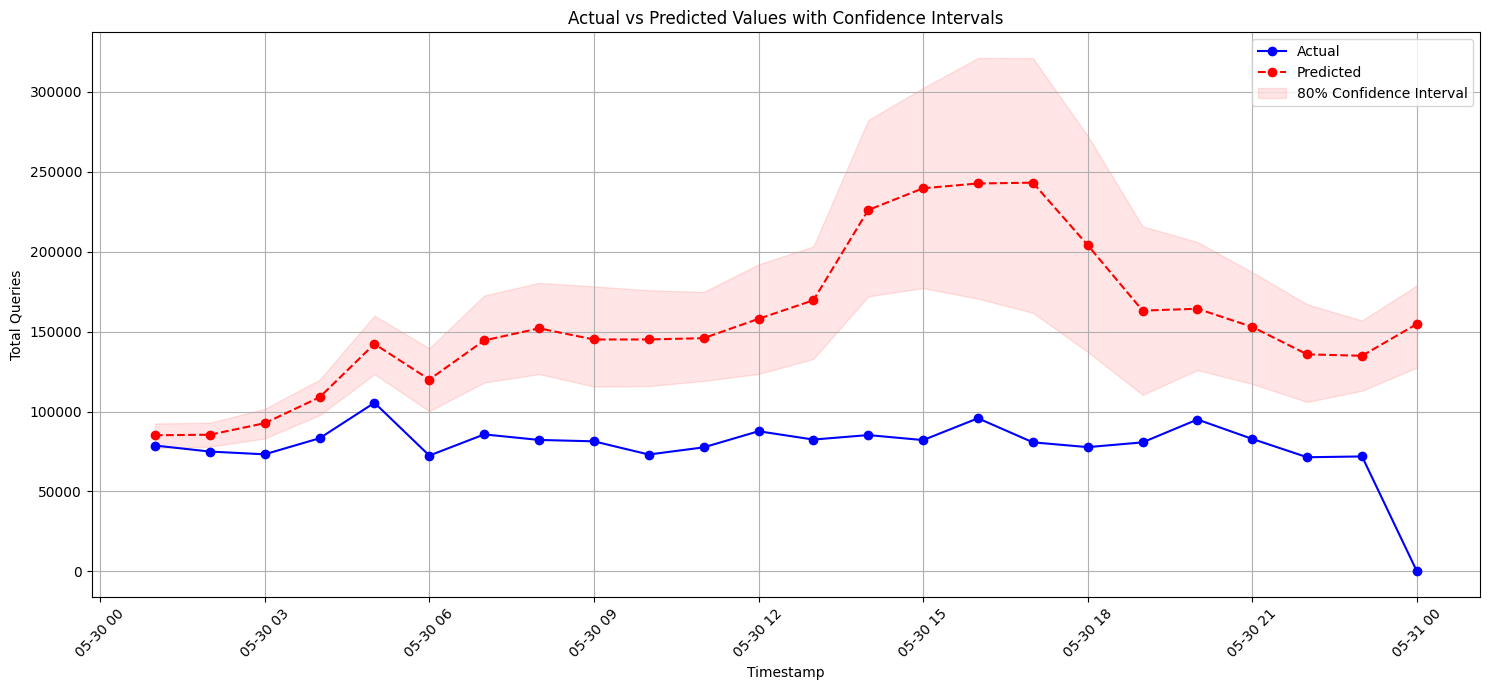

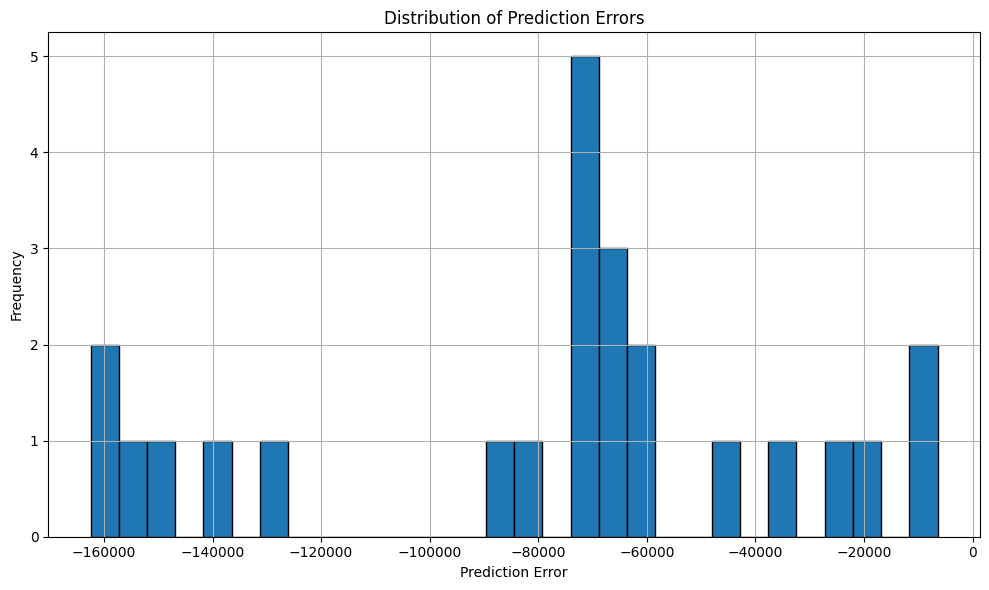

In [10]:
# Convert forecast to pandas DataFrame for easier manipulation
forecast_df = forecast.reset_index()
actual_df = hourly_stats_pd.iloc[-prediction_length:]

# Calculate error metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

actual_values = actual_df[target_column].values
predicted_values = forecast_df['mean'].values

# Calculate metrics
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
r2 = r2_score(actual_values, predicted_values)

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R-squared Score: {r2:.4f}")

# Visualize actual vs predicted values
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 7))

# Plot actual values
plt.plot(actual_df['timestamp'], actual_values, 
         label='Actual', marker='o', linestyle='-', color='blue')

# Plot predicted values with confidence intervals
plt.plot(actual_df['timestamp'], predicted_values, 
         label='Predicted', marker='o', linestyle='--', color='red')

# Add confidence intervals
plt.fill_between(actual_df['timestamp'],
                 forecast_df['0.1'],
                 forecast_df['0.9'],
                 color='red', alpha=0.1,
                 label='80% Confidence Interval')

plt.title('Actual vs Predicted Values with Confidence Intervals')
plt.xlabel('Timestamp')
plt.ylabel('Total Queries')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot error distribution
errors = actual_values - predicted_values
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()